# Algorytm detekcji krawędzi Canny'ego
Opracowanie: A.Florkowska

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as nd
from skimage import color, io
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage import measure
from skimage import feature
import scipy.signal as signal


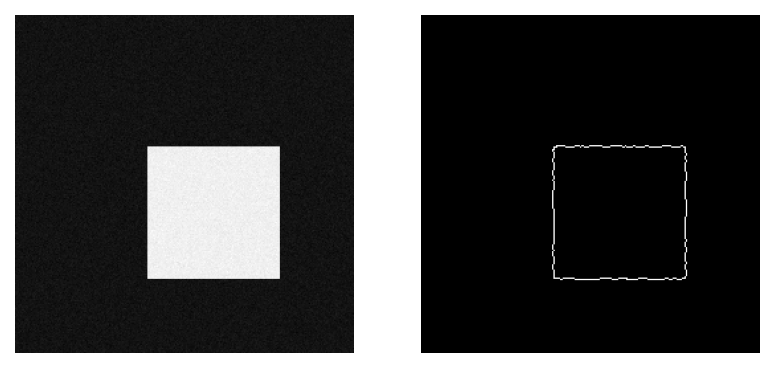

In [2]:
y_size, x_size = 256, 256
image = np.zeros((y_size, x_size))
image[100:200, 100:200] = 1
image = image + np.random.randn(y_size, x_size)*0.02

skimage_canny = feature.canny(image)

plt.figure(dpi=150)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(skimage_canny, cmap='gray')
plt.axis('off')
plt.show()

In [3]:
def gaussian_smoothing(image, sigma, se_size):

  def generate_se(se_size):
    size=se_size// 2
    y,x = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    se =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    se = se / np.sum(se)
    return se

  def generate_size(se, coord):
    if se.shape[coord]==1:
      return 1
    else:
      return int((se.shape[coord] - se.shape[coord]%2)/2)

  dim_y = generate_size(se, 0) 
  dim_x = generate_size(se, 1) 
  
  new_matrix_y=image.shape[0]+int(2*dim_y)
  new_matrix_x=image.shape[1]+int(2*dim_x)

  processed_image = np.zeros((new_matrix_y,new_matrix_x))
  processed_image[dim_y:(dim_y + image.shape[0]), dim_x:(dim_x + image.shape[1])] = image
  final_image = np.zeros((new_matrix_y,new_matrix_x))


  for y in range (dim_y,processed_image.shape[0]):
    for x in range (dim_x,processed_image.shape[1]):
      if ( ((y+2*dim_y)< processed_image.shape[0]) and ((x+2*dim_x) < processed_image.shape[1]) ) :
        temp = np.sum((processed_image[y-dim_y:y+dim_y+1,x-dim_x:x+dim_x+1])* se )
        final_image[y,x] = temp
  
  return final_image


In [4]:
def calculate_gradients(image):
  def sobel_gradient(image):
    window_x = np.array([
      [-1, 0, 1],
      [-2, 0, 2],
      [-1, 0, 1]                     
      ])
    window_y = window_x.T
    gradient_x = signal.correlate2d(image, window_x)
    gradient_y = signal.correlate2d(image, window_y)
    return gradient_y, gradient_x
  
  gradient_magnitude = lambda gradient_x, gradient_y: np.sqrt(gradient_x**2 + gradient_y**2)
  gradient_angle = lambda gradient_x, gradient_y: np.arctan(gradient_y/gradient_x)

  gradient_y, gradient_x = sobel_gradient(image)
  g_mag = gradient_magnitude(gradient_x, gradient_y)
  g_angle = gradient_angle(gradient_x, gradient_y)
  
  return g_mag, g_angle

In [5]:
def non_maximum_supression(gradient_magnitude, gradient_angle):
  y_size, x_size = gradient_magnitude.shape
  potential_edges = np.zeros((y_size,x_size))
  angle = np.rad2deg(angle)+180
  
  for i in range(1,y_size-1):
    for j in range(1,x_size-1):
      pixel_forward = 255
      pixel_backward = 255
                
      
      if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (337.5<=angle[i,j]<=360) :
        pixel_forward = gradient_magnitude[i, j+1]
        pixel_backward = gradient_magnitude[i, j-1]
      
      elif (22.5 <= angle[i,j] < 67.5) or (202.5<=angle[i,j]<247.5):
        pixel_forward = gradient_magnitude[i+1, j-1]
        pixel_backward = gradient_magnitude[i-1, j+1]
      
      elif (67.5 <= angle[i,j] < 112.5) or (247.5<=angle[i,j]<292.5):
        pixel_forward = gradient_magnitude[i+1, j]
        pixel_backward = gradient_magnitude[i-1, j]
      
      else 
        pixel_forward = gradient_magnitude[i-1, j-1]
        pixel_backward = gradient_magnitude[i+1, j+1]

      if (gradient_magnitude[i,j] > pixel_forward) and (gradient_magnitude[i,j] > pixel_backward):
        potential_edges[i,j] = img[i,j]
      else:
        potential_edges[i,j] = 0

  return potential_edges


SyntaxError: expected ':' (1534380311.py, line 24)

In [6]:
def otsu_threshold(image, high_coef, low_coef):
  high_threshold = image.max() * high_coef;
  low_threshold = high_threshold * low_coef ;
  return high_threshold, low_threshold

def double_threshold(potential_edges, gradient_magnitude, low_coef=0.045, high_coef=0.085 ):
  high, low = otsu_threshold(image, high_coef, low_coef) 
  strong_edges = potential_edges[potential_edges >= high]
  weak_edges = potential_edges[(potential_edges <= high) and (potential_edges >= low)]
  return strong_edges, weak_edges

In [7]:
def edge_hysteresis(strong_edges, weak_edges):
  final_edges = np.copy(strong_edges)
  se = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]                     
  ])  
  for i in range(1, strong_edges.shape[0]-1):
    for j in range(1, strong_edges.shape[1]-1):
      if (weak_edges[i, j] == 1):
        try:
          if ( ((i+2)< strong_edges.shape[0]) and ((j+2) < strong_edges.shape[1]) ): #dla bezpieczenstwa
            if (np.max((strong_edges[i-1:i+2,j-1:j+2])* se ) > 0):
              final_edges[i, j] = 1
        except IndexError as e:
          pass
  return final_edges


In [8]:
def normalize(image):
    return (image - np.min(image))/(np.max(image) - np.min(image))

image = io.imread("fotolab4.jpg")
image=normalize(color.rgb2gray(image))

def canny(image, sigma=1.0):
  se_size = 5
  image = gaussian_smoothing(image, sigma, se_size)
  grad_mag , grad_angle = calculate_gradients(image)
  potential_edges = non_maximum_supression(grad_magnitude, grad_angle)
  strong_edges, weak_edges = double_threshold(potential_edges, grad_magnitude)
  edges = edge_hysteresis(strong_edges, weak_edges)
  return edges

final = canny(image, sigma=1.0)

FileNotFoundError: No such file: 'C:\Users\agnie\AFlorkowska\Repos\Image-Processing\PL\fotolab4.jpg'